# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models, utils
from torch import nn, optim
import torch.nn.functional as F
from collections import OrderedDict
import time
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from workspace_utils import active_session
from PIL import Image
import os
import random
from matplotlib.pyplot import imshow

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Global parameters
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
PICTURE_RESIZE = 256
CROP_SIZE = 224
DATA_DIR = 'flowers'

# set the device to GPU if it's available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print('Device type is is to:', DEVICE)

Device type is is to: cpu


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
def dataloader(data_dir, batch_size, picture_resize, crop_size, std, mean):  
    """ 
    Load images and apply transformations using the torchvision transformation and dataloader libary
    
    Images are organized into train, validation and test datasets. 
    Training dataset is randomly augmented

    Args:
        (str) data_dir - main folder where images are stored
        (str) batch_size - number of images that is processed at a time
        (str) picture_resize - resize picture
        (str) crop_size = crop the centre of the image
        (str) std - normalize image colors to standard deviation the model expects
        (str) mean - normalize image colors to mean the model expects
    Returns:
        trainloader - pytorch tenson to load training data
        validationloader - pytorch tenson to load validation data
        testloader - pytorch tenson to load test data
        class_to_idx - return tensor to image folder index conversion table
    """
        
    print("Initializing Datasets and Dataloaders...")

    # set transform parameters
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(picture_resize),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(picture_resize),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),    
    }

    # Load the image datasets with ImageFolder
    data = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
           for x in data_transforms.keys()}  
    
    # return class indexes to save into the model later
    class_to_idx = data['train'].class_to_idx
 
    # Using the image datasets and the transform definitions, define the dataloaders
    trainloader = torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=True)
    validationloader = torch.utils.data.DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(data['test'], batch_size=batch_size, shuffle=False)  
    
    return trainloader, validationloader, testloader, class_to_idx
    
batch_size=64
trainloader, validationloader, testloader, class_to_idx = dataloader(data_dir=DATA_DIR,
                                                                     batch_size=batch_size,
                                                                     picture_resize=PICTURE_RESIZE,
                                                                     crop_size=CROP_SIZE,
                                                                     std=STD,
                                                                     mean=MEAN)

Initializing Datasets and Dataloaders...


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
def get_flowernames():
    """
    Load flower name descriptions. A file called 'cat_to_name.json' should be loaded in the root directory
    
    Returns:
        class_names - names of the flowers
        num_classes - the total number of available flower types
    """
    
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)

    # set number of classes
    num_flowers = len(cat_to_name)
    print('Flower types found: {}'.format(num_flowers))
    
    return cat_to_name, num_flowers

class_names, num_classes = get_flowernames()

Flower types found: 102


### Display a few flowers from the training dataset

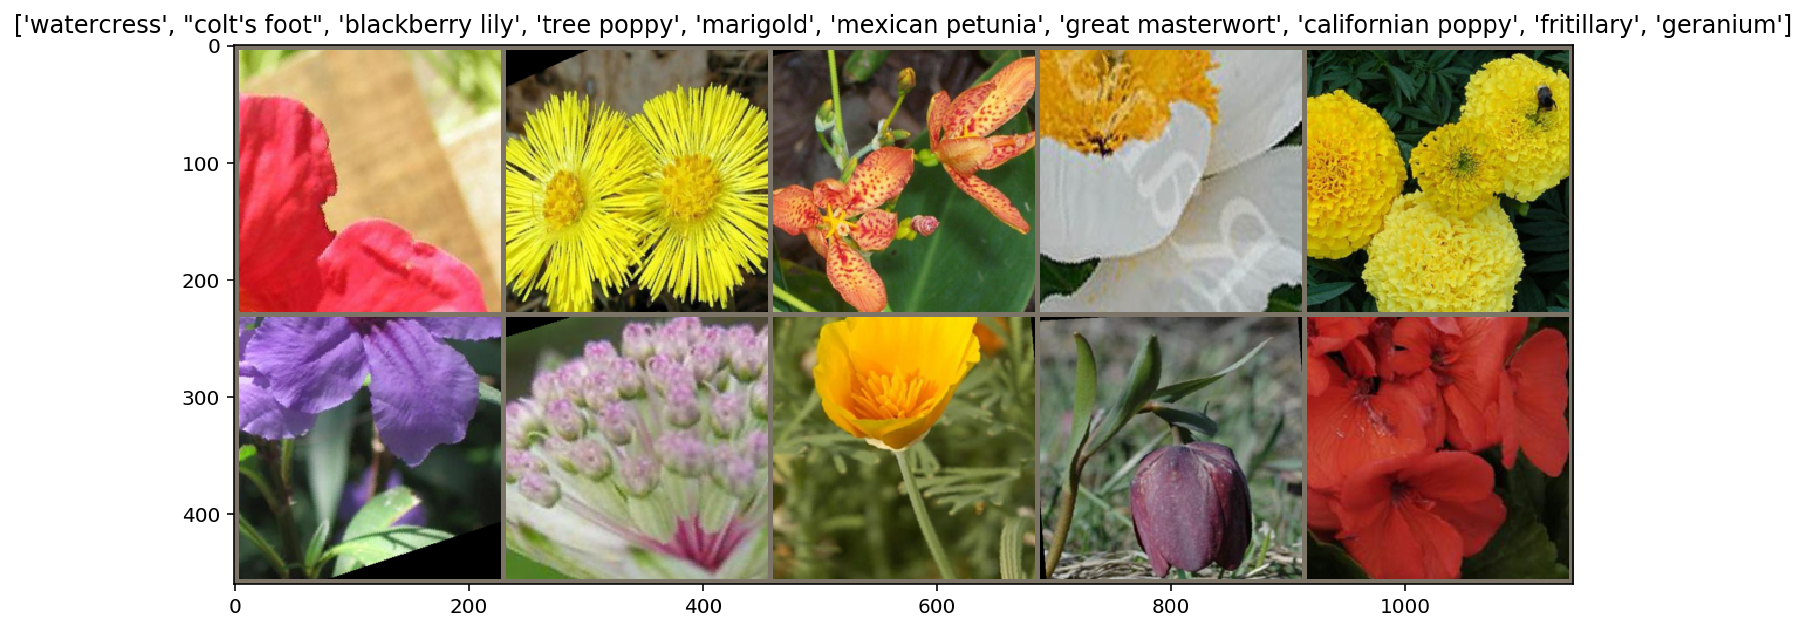

In [5]:
def imshow_grid(inp, title=None):
    """Imshow grid show for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,12))    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(images[:10], nrow=5, scale_each=True, padding=4)

title = []
for i, j in enumerate(labels[:10].flatten()):
    index = list(class_to_idx.keys())[j.item()]
    title.append(class_names[str(index)])

# title=[class_names[str(x.item())] for x in labels[:10]]
title=list(title)
imshow_grid(out, title)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [6]:
def network(model_name, num_classes):
    """ Copy a pretrained VGG model from pytorch and only reconfigure the last FC level
        
        Reference used:
        https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
        
    Args:
        (str) model_name - pytorch model to load, only option 'vgg' available but can be extended
        (str) num_classes - number of classes the last FC layer output will be set to
    Returns:
        model_ft - new model network with last FC layer changed
    """

    model_ft = None
    input_size = 0

    if model_name == "vgg":
        """ VGG11_bn"""
        
        model_ft = models.vgg11_bn(pretrained=True)
        
        # Freeze parameters for the convolutional layers, as this does not need to be retrained
        for param in model_ft.parameters():
            param.requires_grad = False
            
        # redefine the last step of the classifier to output only 102 classes (types of flowers)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        return model_ft

In [7]:
# Create the network and model parameters 
learning_rate = 0.001
momentum=0.95

# instantiate the model
model = network(model_name='vgg', num_classes=num_classes)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[6].parameters(), lr=learning_rate, momentum=momentum)

# send model to GPU
model = model.to(DEVICE)

# Print the model we just instantiated
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
# Double check which parameters are set to be retrained, should only be the last FC level of the model network
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [12]:
def train(model, trainloader, validationloader, criterion, optimizer, epochs=2):
    """ Train the model
        
    Args:
        (str) model - model to be used to train
        (DataLoader) trainloader - pytorch dataloader to load training data
        (DataLoader) validationloader - pytorch dataloader to load validation data
        criterion - loss function to use
        (optim) optimizer - optimizer containing parameters to retrain
        (str) epochs - number of training cycles
    Returns:
        model - trained pytorch model
        optimizer - trained optimizer
        train_losses - losses per epoch
        validation_losses - losses per epoch
    """
    
    
    print('Initiating Training....')
#     with active_session():    
    
    train_losses, validation_losses = [], []        
    for e in range(epochs):

        # Model in training mode, dropout is on, gradient descent calculations is on
        model.train()

        running_loss = 0
        for images, labels in trainloader:

            # Move input and label tensors to the default device
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:
            validation_loss = 0
            accuracy = 0

            # Model in inference mode, no dropout
            model.eval()

            with torch.no_grad():
                for inputs, labels in validationloader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    output = model.forward(inputs)
                    loss = criterion(output, labels)

                    validation_loss += loss.item()

                    # Calculate accuracy
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            validation_losses.append(validation_loss/len(validationloader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Validation Loss: {:.3f}.. ".format(validation_loss/len(validationloader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(validationloader)))

    return model, optimizer, train_losses, validation_losses

In [13]:
epochs = 20
model, optimizer, train_losses, validation_losses = train(model, trainloader, validationloader, 
                                                          criterion, optimizer, epochs=epochs)

Initiating Training....
Epoch: 1/20..  Training Loss: 3.832..  Validation Loss: 2.675..  Validation Accuracy: 0.472
Epoch: 2/20..  Training Loss: 2.509..  Validation Loss: 1.755..  Validation Accuracy: 0.689
Epoch: 3/20..  Training Loss: 1.893..  Validation Loss: 1.281..  Validation Accuracy: 0.780
Epoch: 4/20..  Training Loss: 1.568..  Validation Loss: 1.032..  Validation Accuracy: 0.844
Epoch: 5/20..  Training Loss: 1.381..  Validation Loss: 0.876..  Validation Accuracy: 0.852
Epoch: 6/20..  Training Loss: 1.233..  Validation Loss: 0.767..  Validation Accuracy: 0.866
Epoch: 7/20..  Training Loss: 1.152..  Validation Loss: 0.710..  Validation Accuracy: 0.879
Epoch: 8/20..  Training Loss: 1.061..  Validation Loss: 0.639..  Validation Accuracy: 0.886
Epoch: 9/20..  Training Loss: 1.026..  Validation Loss: 0.590..  Validation Accuracy: 0.894
Epoch: 10/20..  Training Loss: 0.957..  Validation Loss: 0.556..  Validation Accuracy: 0.904
Epoch: 11/20..  Training Loss: 0.921..  Validation Loss

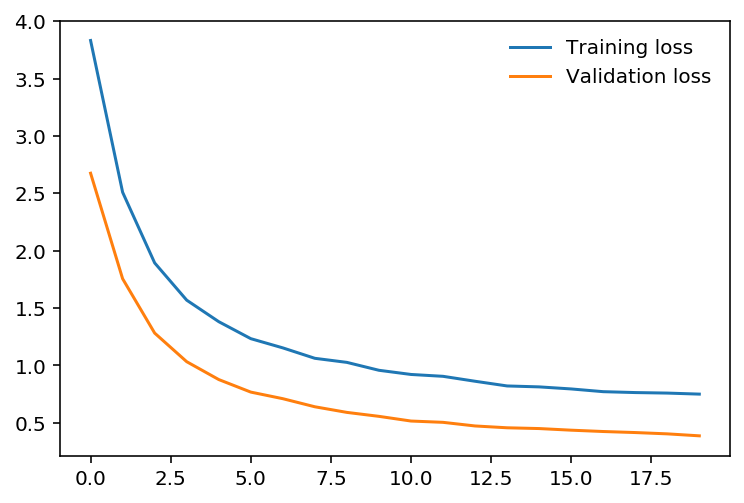

In [14]:
# Plot training vs validation accuracy
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
def test(model, testloader, criterion):
    
    test_loss = 0
    accuracy = 0

    # Model in inference mode, no dropout
    model.eval()

    test_losses = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            output = model.forward(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        test_losses.append(test_loss/len(testloader))

        print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
    return accuracy/len(testloader)
        
test_accuracy = test(model, testloader, criterion)

Test Loss: 0.470..  Test Accuracy: 0.899


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [49]:
# print and save trained model results
print('Saving checkpoint...')

checkpoint_path = 'checkpoint.pth'

checkpoint = {'input_size': model.classifier[6].in_features,
              'output_size': num_classes,
              'batch_size': batch_size,
              'epochs': epochs,
              'class_to_idx': class_to_idx,
              'model': model,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'learning_rate': learning_rate,
              'momentum': momentum}
              
torch.save(checkpoint, checkpoint_path)

Saving checkpoint...


In [ ]:
file =

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [53]:
def load_checkpoint(filepath):

    print('Loading checkpoint.....')
    
    checkpoint = torch.load(filepath)

    model = checkpoint['model']
    optimizer = optim.SGD(model.classifier[6].parameters(), 
                          lr=checkpoint['learning_rate'], momentum=checkpoint['momentum'])
    

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epochs = checkpoint['epochs']
    
    return model, optimizer, checkpoint

new_model, new_optimizer, checkpoint = load_checkpoint(checkpoint_path)

Loading checkpoint.....


In [55]:
# Double check which parameters are set to be retrained for the newly loaded model from checkpoint
params_to_update = new_model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in new_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [27]:
def process_image(image, picture_resize, crop_size, mean, std):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model
    
    Reference: https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7
    
    Returns:
        tensor_image - Transformed PIL image converted into a tensor
    """
    
    # Get the dimensions of the image
    width, height = image.size

    # Resize the picture
    size = (picture_resize, picture_resize)
    image.thumbnail(size)
    
    # Crop picture to same size as pytorch tensors in dataloaders
    width, height = image.size
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    image = image.crop((left, top, right, bottom))

    # change colours from range 0-255 to 0-1
    np_image = np.array(image)/256
    
    # Normalize based on the preset mean and standard deviation
    np_image = (np_image - mean) / std
    
    # color channel should be first column, then height and width
    np_image = np.transpose(np_image, (2, 0, 1))
    
    # turn image into a tensor object
    tensor_image = torch.from_numpy(np_image)
    tensor_image = tensor_image.float()
   
    return tensor_image

In [19]:
def imshow_tensor(image, mean, std, ax=None, title=None):
    """Imshow for Tensor showing 1 image, showing cropping and resizing results"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
#     # Undo preprocessing
    image = image * std + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

In [21]:
def select_image(image_path, class_names):
    """
    Randomly selecct and image from the test folder
    
    Args:
    (str) image_path - folder where the testing data is stored
    (str) class_names - names of the flowers
    
    Returns:
    img - PIL image randomly selected and opened, without any transformations
    name - actual name of the flower for validation purposes
    """
    
    class_selection = random.choices(os.listdir(image_path), k=1)[0]
    name = class_names[str(class_selection)]
    image_class_path = image_path + class_selection + '/'
    image_full_path = image_class_path + random.choices(os.listdir(image_class_path), k=1)[0]
    img = Image.open(image_full_path)
    return img, name

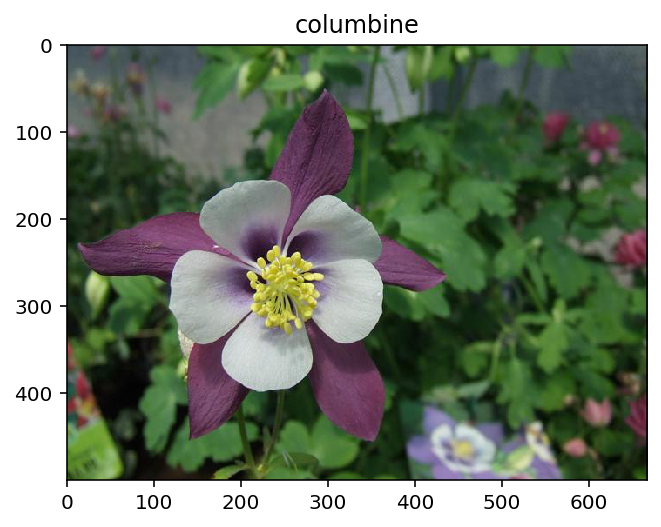

In [22]:
# Load a random image from test folder
image_path = DATA_DIR + '/test/'
image, class_name = select_image(image_path, class_names)

# display the unnormalized picture
plt.title(class_name)
plt.imshow(np.uint8(image))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

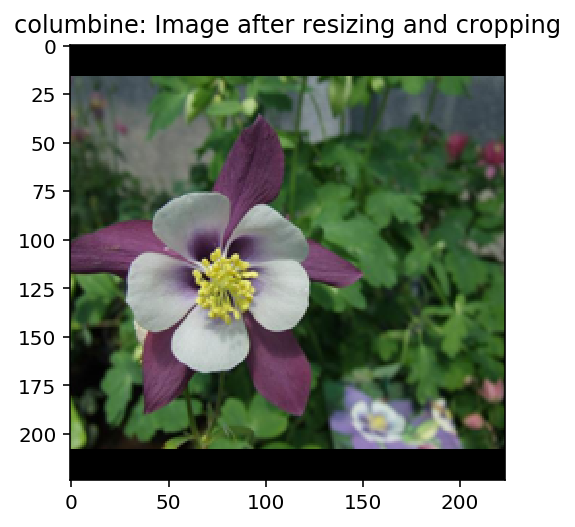

In [28]:
# convert PIL image from cell above to a tensor image. Use same paramaters the tensor loaders used above
tensor_image = process_image(image, PICTURE_RESIZE, CROP_SIZE, MEAN, STD)

# display the image after resizing and cropping
imshow_tensor(tensor_image, MEAN, STD, title=class_name + ': Image after resizing and cropping')

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [38]:
def predict(image, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    model.eval()
    tensor_image = process_image(image, PICTURE_RESIZE, CROP_SIZE, MEAN, STD)
    # Add a fourth dimension to the beginning to indicate batch size
    tensor_image = tensor_image[np.newaxis,:]   
        
    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(tensor_image)
    
    ps = output.softmax(dim=1)    
    probs, classes = ps.topk(topk, dim=1)
    
    return probs, classes

# randomly select an image from the test folder
PIL_image, actual_name = select_image(image_path, class_names)

# predict which flower type it is
probs, classes = predict(PIL_image, new_model)
print(probs)
print(classes)

# get the class names for the topk predicted classes
top_class_names = []
for i, j in enumerate(classes.numpy().squeeze()):
    index = list(checkpoint['class_to_idx'].keys())[j.item()]
    top_class_names.append(class_names[str(index)])
print(top_class_names)

tensor([[0.8908, 0.0239, 0.0107, 0.0106, 0.0063]])
tensor([[93, 85, 91, 83, 84]])
['hippeastrum', 'columbine', 'monkshood', 'clematis', 'hibiscus']


In [45]:
test = classes.numpy().squeeze()
test

array([93, 85, 91, 83, 84])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [41]:
def view_classify(img, probs, top_class_names, actual_class_name):
    ''' Function for viewing an image and it's predicted classes.
    '''
    probs = probs.data.numpy().squeeze()
    print(probs)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)
    ax1.set_title(actual_class_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    ax2.invert_yaxis()    
    ax2.barh(np.arange(5), probs)
    ax2.set_yticks(np.arange(5))
    
    ax2.set_yticklabels(top_class_names, size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()

[0.89084    0.02385826 0.01065027 0.01063013 0.00627315]


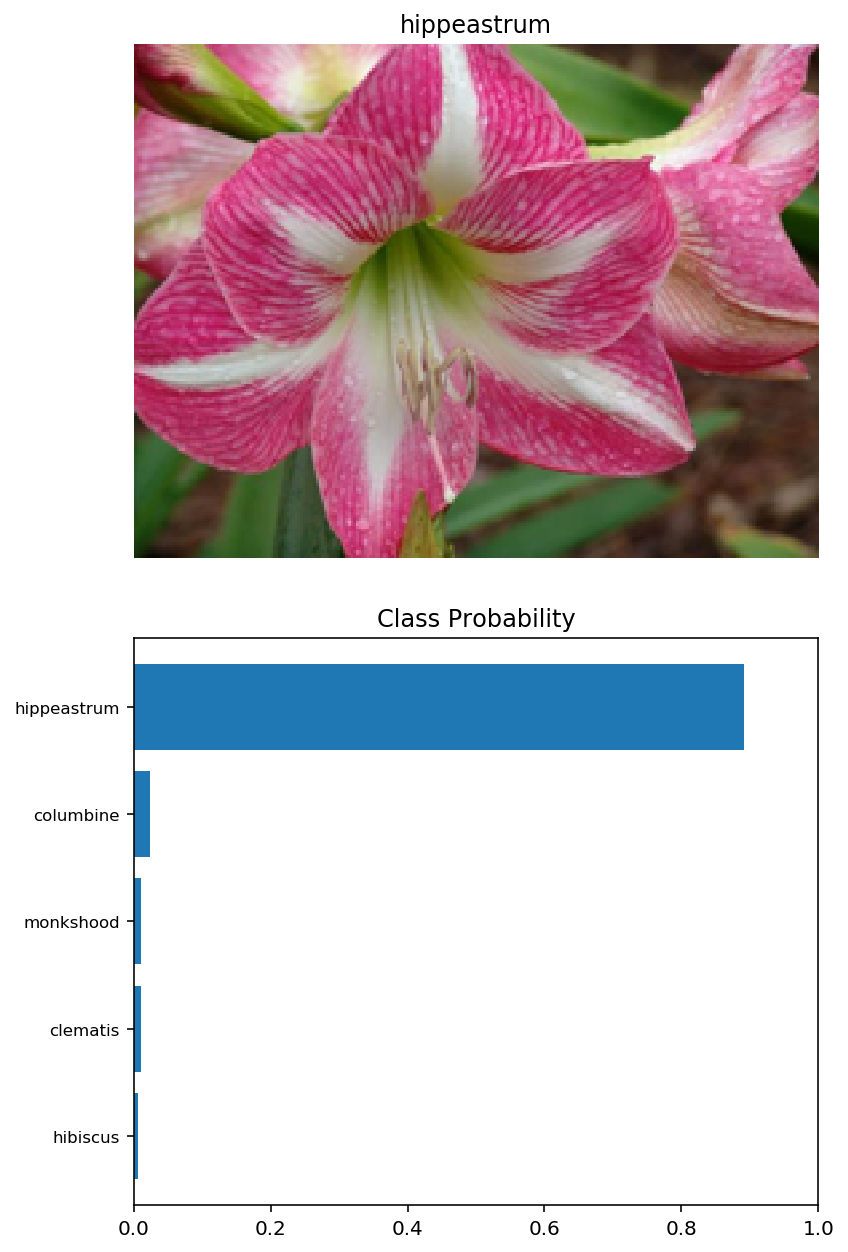

In [42]:
# visualize results
view_classify(PIL_image, probs, top_class_names, actual_name)